# Analysis of Airbnb in Boston and Seattle<a class="tocSkip">

## Availability, Pricing, and Reviews<a class="tocSkip">

---

## Motivation and Business Questions

This project is an exercise in quantitative, business research using public Airbnb data for the cities of [Boston](https://www.kaggle.com/airbnb/boston) and [Seattle](https://www.kaggle.com/airbnb/seattle/data). 

The main analysis in the project is an investigation of the following 3 questions:

>1. How does the average availability of Airbnb homes vary over time in each city? How does it compare between cities?
>2. Is there a clear seasonal pattern for the average nightly rate on Airbnb in Boston and Seattle? Is there a clear weekly pattern?
>3. Is there a clear association between a listing’s nightly rate and the number of guest reviews the home has received?

---
## Understanding the Airbnb data

The project relies on three analogous datasets for each city:

* `listings.csv`: including full descriptions and average review score 
* `reviews.csv`: including unique id for each reviewer and detailed comments 
* `calendar.csv`: including listing id and the price and availability for that day

Six (6) `csv` files in total.

### Import Python libraries

In [27]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import sys

# Import plotting modules
import matplotlib.pyplot as plt
import matplotlib.dates as plotdates
import matplotlib.ticker as ticker
import seaborn as sns

# Import StatsModels modules
import statsmodels.api as sm

In [28]:
# Print Python version for future reference
print(sys.version)

3.7.1 (default, Oct 23 2018, 14:07:42) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [29]:
# Import utility functions from utility_fs.py
import utility_fs as utils

The file `utility_fs.py` contains 11 functions that I created to do most of the heavy lifting concerning visualization and analysis, while avoiding duplicated code. 

In [30]:
# IPython magic commands
# Autoreload 'utility_fs' when changes are made
%load_ext autoreload
%autoreload 1
%aimport utility_fs

# Display plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Set plots aesthetic parameters in one step.
sns.set(context='notebook', color_codes=True, font='sans-serif', 
        font_scale=1.15)

### Load the data

The data will be stored in a hierarchical dictionary with city — Boston, Seattle — as the first level and dataset type — calendar, listings, reviews — as the second level. 

In [32]:
# Specify paths to data and filenames
cities = ['Boston', 'Seattle']
filenames = ['calendar', 'listings', 'reviews']

In [33]:
# Read csv files and store in hierarchical dictionary
data = dict()

# Loop over cities
for city in cities:
    data[city] = dict()
    # Loop over files
    for filename in filenames:
        # Read csv into dictionary
        path = 'data/' + city + '/' + filename + '.csv'
        data[city][filename] = pd.read_csv(path, sep=',', quotechar='"')

The `data` dictionary now contains all the primary data I will be using for this project. For example, the `calendar.csv` data for Boston is a Pandas DataFrame that is returned by the expression `data['Boston']['calendar']`.

### High-level description of datasets

This high-level inspection of the datasets involves two main objectives. 
1. Determine the size and shape of the datasets. 
2. Identify the major properties of the datatypes in each DataFrame by inspecting the first few rows of as many columns as possible.

The utility function `print_data()` provides a high-level view of the content of the datasets we are working with. The information printed by the function is described below:

1. Shape — total rows x total columns — of all 3 datasets for the city.
2. First n rows of `calendar.csv`.
3. First n rows of `listings.csv`.
4. First n rows of `reviews.csv`.

#### Boston datasets

In [34]:
# Call 'print_data()' for Boston
utils.print_data(data=data, city='Boston', rows=1)

(1) Shape of datasets for Boston:

calendar.csv - 1,308,890 x  4
listings.csv -     3,585 x 95
 reviews.csv -    68,275 x  6

(2) First few rows of Boston's calendar.csv:


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN



(3) First few rows of Boston's listings.csv:


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN



(4) First few rows of Boston's reviews.csv:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...


#### Seattle datasets

In [35]:
# Call 'print_data()' for Seattle
utils.print_data(data=data, city='Seattle', rows=1)

(1) Shape of datasets for Seattle:

calendar.csv - 1,393,570 x  4
listings.csv -     3,818 x 92
 reviews.csv -    84,849 x  6

(2) First few rows of Seattle's calendar.csv:


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00



(3) First few rows of Seattle's listings.csv:


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07



(4) First few rows of Seattle's reviews.csv:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...


Above we can see that the datasets are analogous for the two cities, with some minor exceptions involving the number of features in the `listings.csv` datasets, as described below:

- `calendar.csv`:  Time-series data for the Airbnb homes including availability and price.
<br> - Boston: 1,308,890 home by date pairings (rows) x  4 features (columns).
<br> - Seattle: 1,393,570 home by date pairings (rows) x  4 features (columns). 


- `listings.csv`:  Listing-level data for the Airbnb homes.
<br> - Boston: 3,585 homes/listings (rows) x  95 features (columns).
<br> - Seattle: 3,818 homes/listings (rows) x  92 features (columns). 


- `reviews.csv`:  Review-level data for the Airbnb homes.
<br> - Boston: 68,275 reviews (rows) x  6 features (columns).
<br> - Seattle: 84,849 reviews (rows) x  6 features (columns).

---
## Assessing missing data

First, I will look at the total proportion of missing values in the datasets. Individually these proportions are not very useful, but as a whole they may suggest systematic problems with the data, such as:

1. The pattern of total missing values across all 3 datasets of one of the cities differs substantially from the other city. 
2. One of the data sources, e.g. `reviews.csv`, has a major missing values problem for one city but not for the other city. 

Both of these potentially problematic scenarios may prompt us to separate the analyses of the two cities, in order to avoid merging data sources that are systematically different with respect to missing values. 

In [36]:
# Print title 
print('Percentage of total missing values in data')

# Loop over cities
for city, values in data.items():
    print('\n{}:'.format(city))
    # Loop over datasets
    for name, df in values.items():
        # Calculate total percentage of missing values
        pc = df.isnull().sum().sum() / df.size
        print('{}.csv: {:>2.2%}'.format(name, pc))

Percentage of total missing values in data

Boston:
calendar.csv: 12.72%
listings.csv: 14.75%
reviews.csv: 0.01%

Seattle:
calendar.csv: 8.23%
listings.csv: 8.49%
reviews.csv: 0.00%


The pattern of total missing values across the calendar, listings, and reviews datasets seems to be the same for the two cities. This leads me to believe that the two cities can be analyzed together without a major concern regarding missing values introducing significant bias. 

### Missing data by column

In this section I analyze the patterns of missing data within columns. The purpose of this assessment is to determine which features can be used for the main analyses and which features may be problematic due to either too many missing values or missing data that occurs in a systematic way. 

The utility function `hist_miss_by_cols()` used below builds histograms to visualize the distribution of missing data by column, measured as percentage of missing values. 

Let's first look at all the data at once:

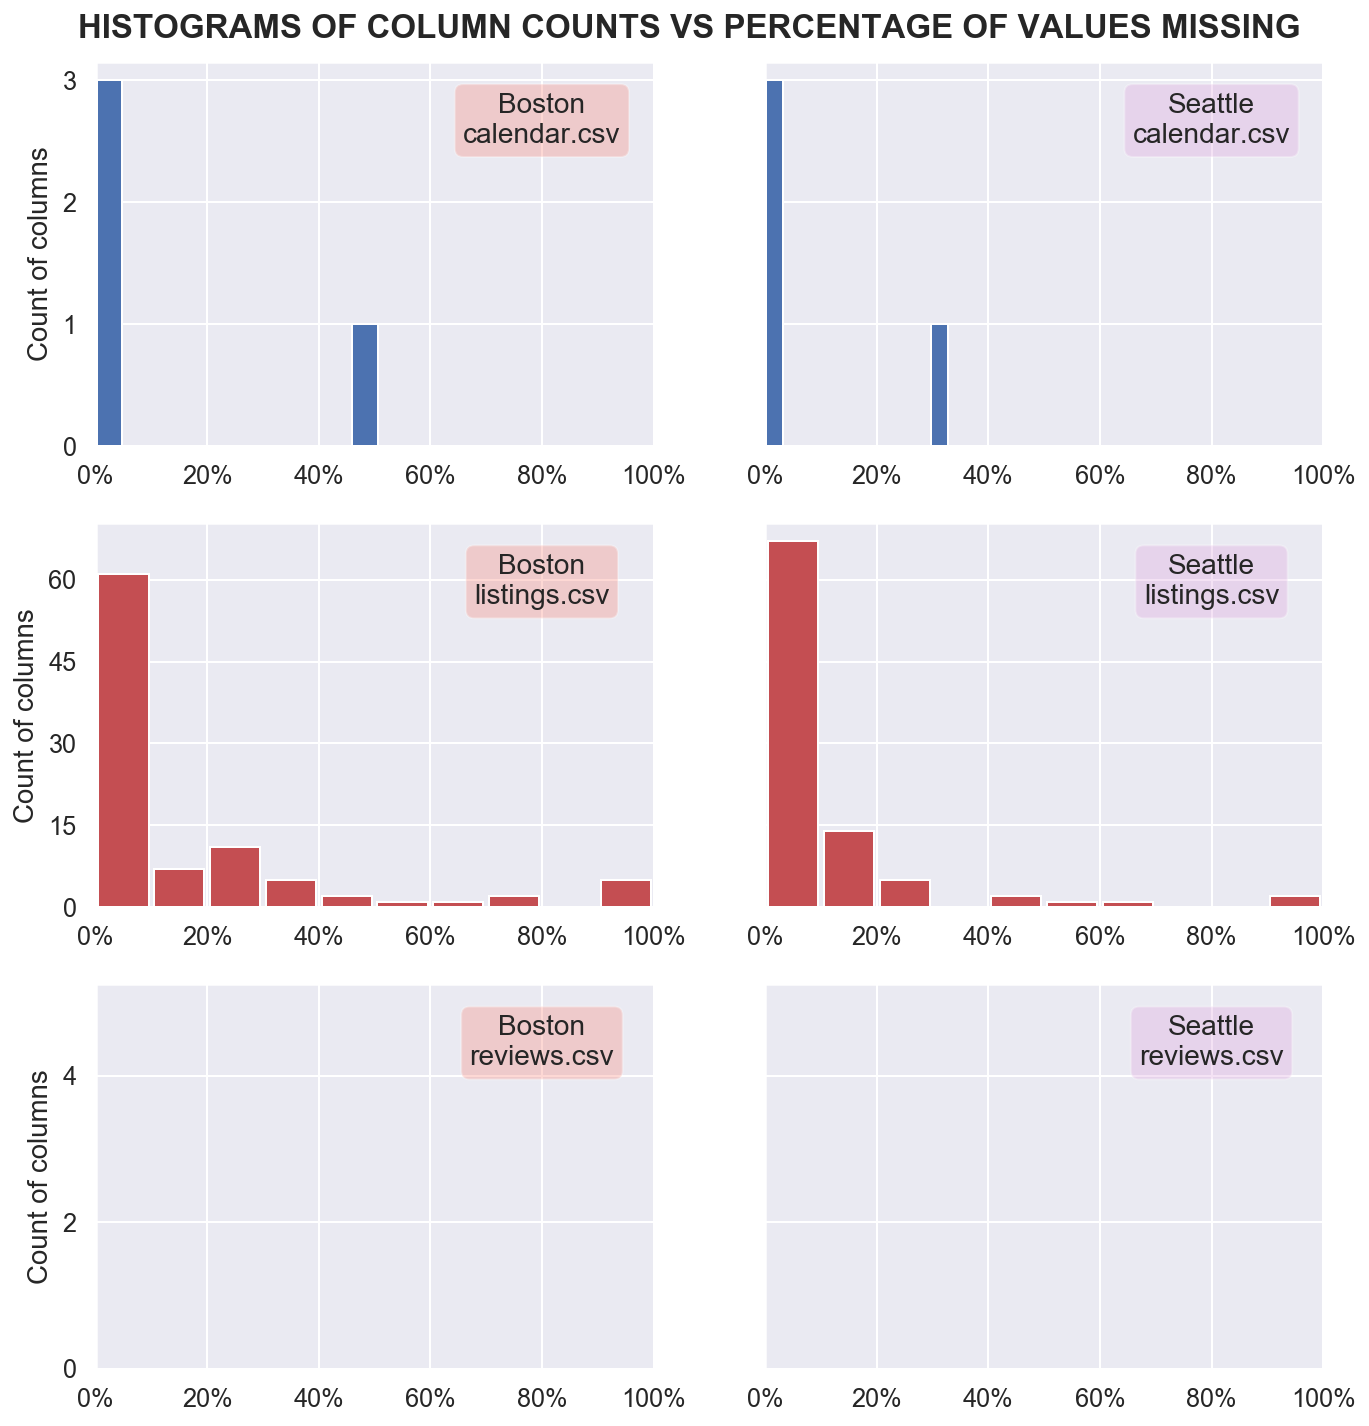

In [37]:
# Call function 'hist_miss_by_cols()'
utils.hist_miss_by_cols(data, data_name='all')

These histograms show that the patterns of missing data are similar across the two cities, but vary significantly between the 3 datasets of a single city. 

The following sections assess each dataset separately. 

#### Columns in `calendar.csv`

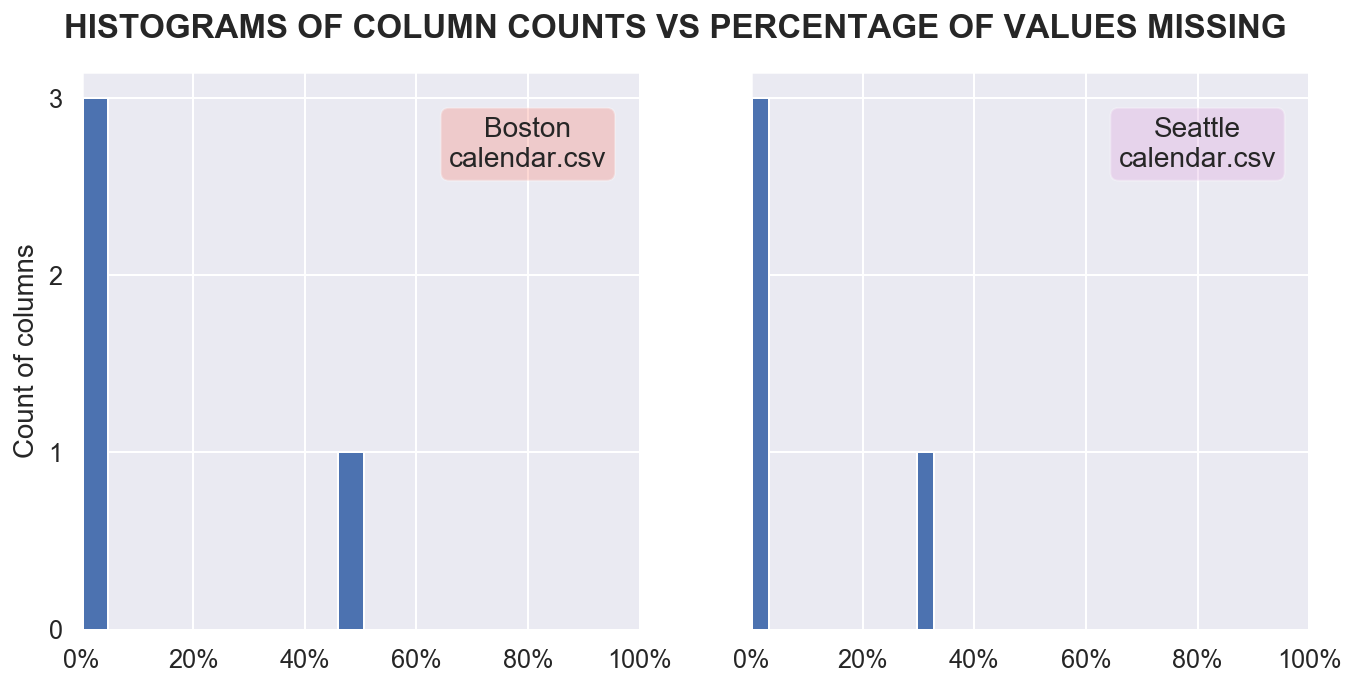

In [38]:
# Call function 'hist_miss_by_cols()'
utils.hist_miss_by_cols(data, data_name='calendar')

The histograms show that 1 of the 4 columns in `calendar.csv` presents a possible problem concerning missing values. 

Let's explore this further by calling the utility function `missing_by_column()`, which prints the percentage of missing values per column for a given dataset and both cities, in descending order of percentage of values missing.  

In [39]:
# Call function 'missing_by_column()'
utils.missing_by_column(data, data_name='calendar')

Percent missing values per column in calendar.csv

       — Boston —        
price         50.9%
available      0.0%
date           0.0%
listing_id     0.0%
dtype: object

       — Seattle —       
price         32.9%
available      0.0%
date           0.0%
listing_id     0.0%
dtype: object


All of the missing values in `calendar.csv` correspond to the feature `price`. 

Given the presence of another feature called `available`, the most reasonable explanation of this behavior is that `price` only takes values for dates in which the Airbnb listing is recorded as available. 

I check this hyphothesis below, by separating the dataset based on whether listings are recorded as available or not. 

In [40]:
# Helper function
def pc_missing_price(status='available'):
    """Print percent of 'price' values missing, given 
    availability status.

    Args: 
        status (str): 'available' or 'unavailable'.

    """
    if status == 'available':
        code = 't'
    elif status == 'unavailable':
        code = 'f'
    print('\n(a) When listing is {}:'.format(status))
    
    # Loop over cities
    for city, values in data.items():
        df = values['calendar'][values['calendar']['available'] == code]
        pc = df['price'].isnull().sum() / df.shape[0] * 100
        print('{:7} {:>4.0f}%'.format(city, pc))

In [41]:
# Print title
print('Proportion of "price" values missing in calendar.csv')

# Missing values when listing is available
pc_missing_price(status='available')

# Missing values when listing is not available
pc_missing_price(status='unavailable')

Proportion of "price" values missing in calendar.csv

(a) When listing is available:
Boston     0%
Seattle    0%

(a) When listing is unavailable:
Boston   100%
Seattle  100%


Hence, we can confirm that missing values in `price` only occur when the listing is recorded as unavailable, which means that the missing values are not a problem of the data in `calendar.csv`.

The next step is to create a container, `keep_features`, which stores the names of the columns to be kept for the main analyses. 

In [42]:
# Create a dictionary to track unproblematic features 
# to keep for subsequent analyses 
keep_features = dict()
keep_features['calendar'] = set(data['Boston']['calendar'].columns)

#### Columns in `listings.csv`

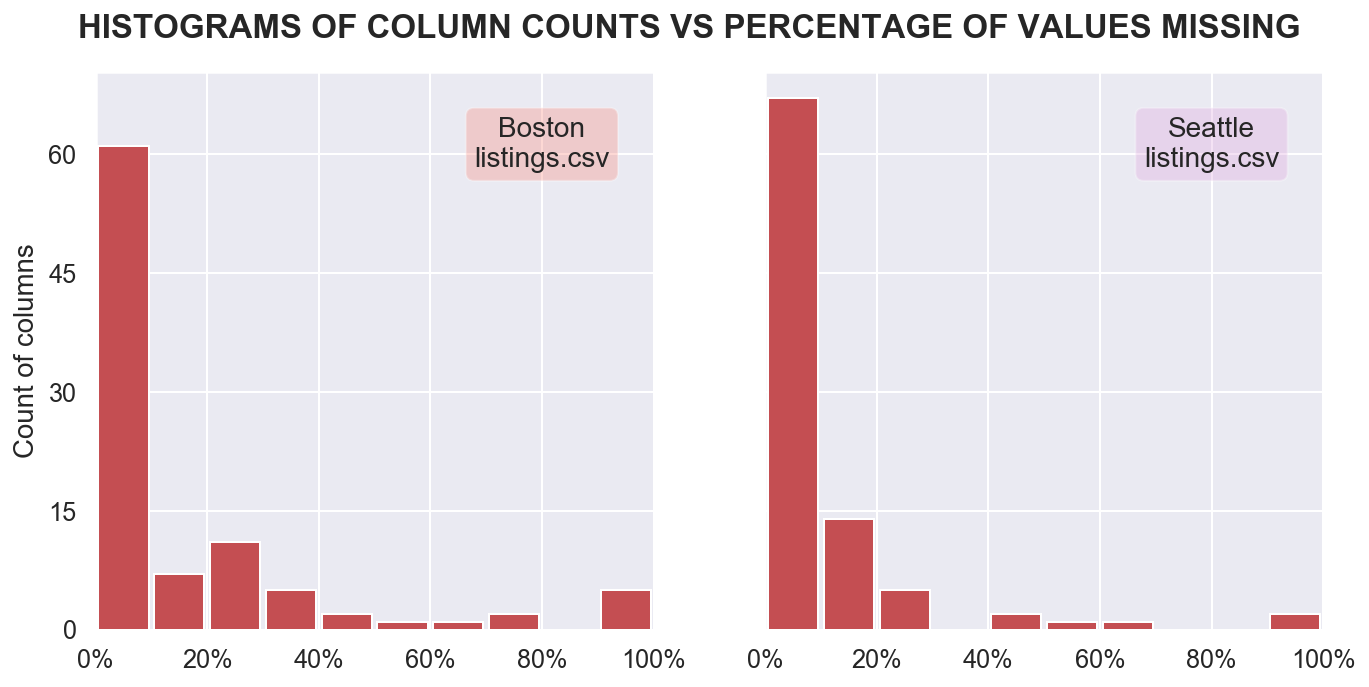

In [43]:
# Call function 'hist_miss_by_cols()'
utils.hist_miss_by_cols(data, data_name='listings')

At a high level, the `listings.csv` datasets do seem to be affected by problems of systematic missing data, including the obvious issue of having some columns with 100% missing values. 

Let’s explore this in detail:

In [ ]:
# Call function 'missing_by_column()'
utils.missing_by_column(data, data_name='listings', n_features=20)

Percent missing values per column in listings.csv

       — Boston —        
neighbourhood_group_cleansed    100.0%
jurisdiction_names              100.0%
license                         100.0%
has_availability                100.0%
square_feet                      98.4%
monthly_price                    75.2%
weekly_price                     75.1%
security_deposit                 62.6%
notes                            55.1%
interaction                      43.3%
access                           41.5%
neighborhood_overview            39.5%
host_about                       36.5%
transit                          36.0%
house_rules                      33.2%
cleaning_fee                     30.9%
space                            29.5%
review_scores_accuracy           23.0%
review_scores_location           22.9%
review_scores_value              22.9%
review_scores_checkin            22.9%
dtype: object

       — Seattle —       
license                        100.0%
square_feet              

Based on the results above (i.e., percentage of missing values per column), I will drop the columns `license`, `neighbourhood_group_cleansed`, `has_availability`, `jurisdiction_names` due to having 100%  missing values. Also, I will drop `square_feet` which has approximately 98% missing values. 

The rest of features that include a large percentage of missing values — e.g., ` weekly_price`, `monthly_price` — will be kept, since the existence of any value for these features in a listing could be relevant.  

In [ ]:
# Features to drop due to missing data
drop_features = set([
    'license', 
    'neighbourhood_group_cleansed', 
    'has_availability', 
    'jurisdiction_names', 
    'square_feet'
    ])

Update the container `keep_features` to track columns in `listings.csv`:

In [ ]:
# Get list of all original features in 'listings.csv'
features_boston = set(data['Boston']['listings'].columns)
features_seattle = set(data['Seattle']['listings'].columns)
# Only keep features in both datasets but in the set of features to drop
keep_features['listings'] = (features_boston & features_seattle) \
                            - drop_features

#### Columns in `reviews.csv`

Since `reviews.csv` has only 6 columns and almost no missing data, I will not plot the histograms and will rely on displaying the column-level missing data statistics. 

In [ ]:
# Call function 'missing_by_column()'
utils.missing_by_column(data, data_name='reviews')

Percent missing values per column in reviews.csv

       — Boston —        
comments         0.1%
reviewer_name    0.0%
reviewer_id      0.0%
date             0.0%
id               0.0%
listing_id       0.0%
dtype: object

       — Seattle —       
comments         0.0%
reviewer_name    0.0%
reviewer_id      0.0%
date             0.0%
id               0.0%
listing_id       0.0%
dtype: object


The `reviews.csv` datasets for both cities have the same features and missing values are negligible. Therefore, I will keep all 6 features. 

Update the container `keep_features` to track columns in `reviews.csv`:

In [ ]:
keep_features['reviews'] = set(data['Boston']['reviews'].columns)

### Missing data by row
Having considered the patterns of missing data within columns, we now move to a similar exercise within rows. 

The utility function `count_rows_missing()` used below performs two tasks:
1. Prints the count of rows per number of features missing. That is, it iterates from zero to the total number of features (or columns) and shows how many rows in the dataset are associated with that number of missing features. 
2. Displays a histogram to visualize the distribution of missing features per row in the dataset.
#### Rows in `calendar.csv`

Count of rows per number of missing features in calendar.csv

Boston:
 0 of  4 missing: 643,037 rows
 1 of  4 missing: 665,853 rows


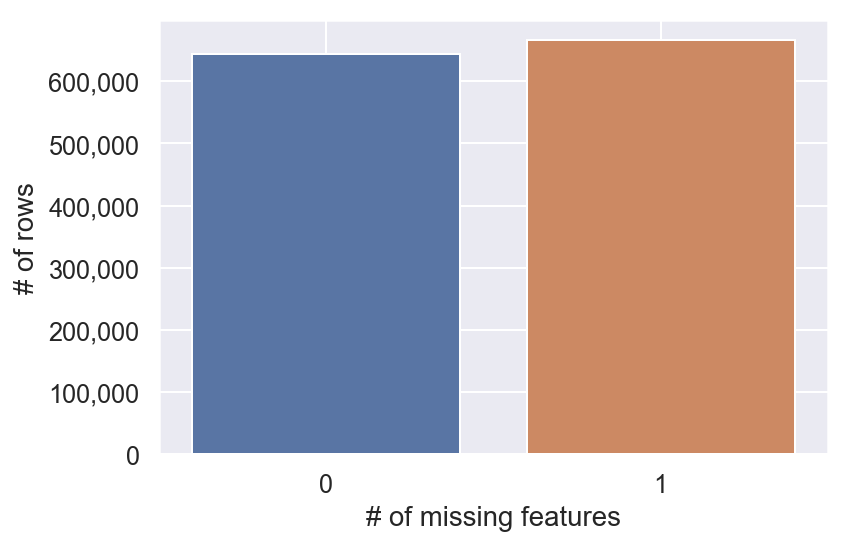

In [ ]:
# Call function 'count_rows_missing()'
utils.count_rows_missing(data=data, city='Boston', data_name='calendar')

Count of rows per number of missing features in calendar.csv

Seattle:
 0 of  4 missing: 934,542 rows
 1 of  4 missing: 459,028 rows


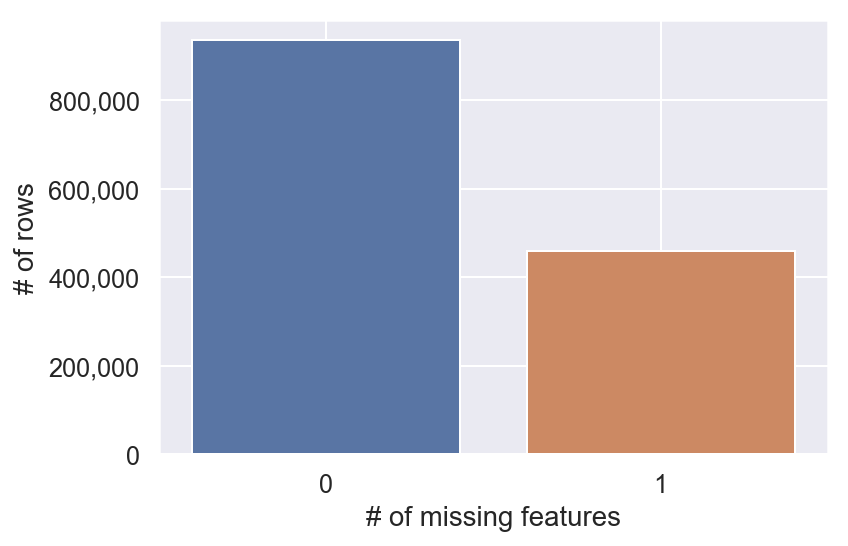

In [ ]:
# Call function 'count_rows_missing()'
utils.count_rows_missing(data=data, city='Seattle', data_name='calendar')

The figures above are consistent with the analysis in the previous section. Many rows have a missing value in the `price` column, which is associated with a listing being unavailable. So it seems that we don't have any problematic rows.

#### Rows in `listings.csv`

Count of rows per number of missing features in listings.csv

Seattle:
 1 of 92 missing:   8 rows
 2 of 92 missing: 302 rows
 3 of 92 missing: 404 rows
 4 of 92 missing: 464 rows
 5 of 92 missing: 564 rows
 6 of 92 missing: 400 rows
 7 of 92 missing: 312 rows
 8 of 92 missing: 268 rows
 9 of 92 missing: 168 rows
10 of 92 missing: 130 rows
11 of 92 missing:  77 rows
12 of 92 missing:  50 rows
13 of 92 missing:  56 rows
14 of 92 missing:  41 rows
15 of 92 missing:  59 rows
16 of 92 missing:  76 rows
17 of 92 missing:  59 rows
18 of 92 missing:  77 rows
19 of 92 missing:  58 rows
20 of 92 missing:  53 rows
21 of 92 missing:  58 rows
22 of 92 missing:  38 rows
23 of 92 missing:  34 rows
24 of 92 missing:  38 rows
25 of 92 missing:  10 rows
26 of 92 missing:   8 rows
27 of 92 missing:   3 rows
29 of 92 missing:   2 rows
33 of 92 missing:   1 rows


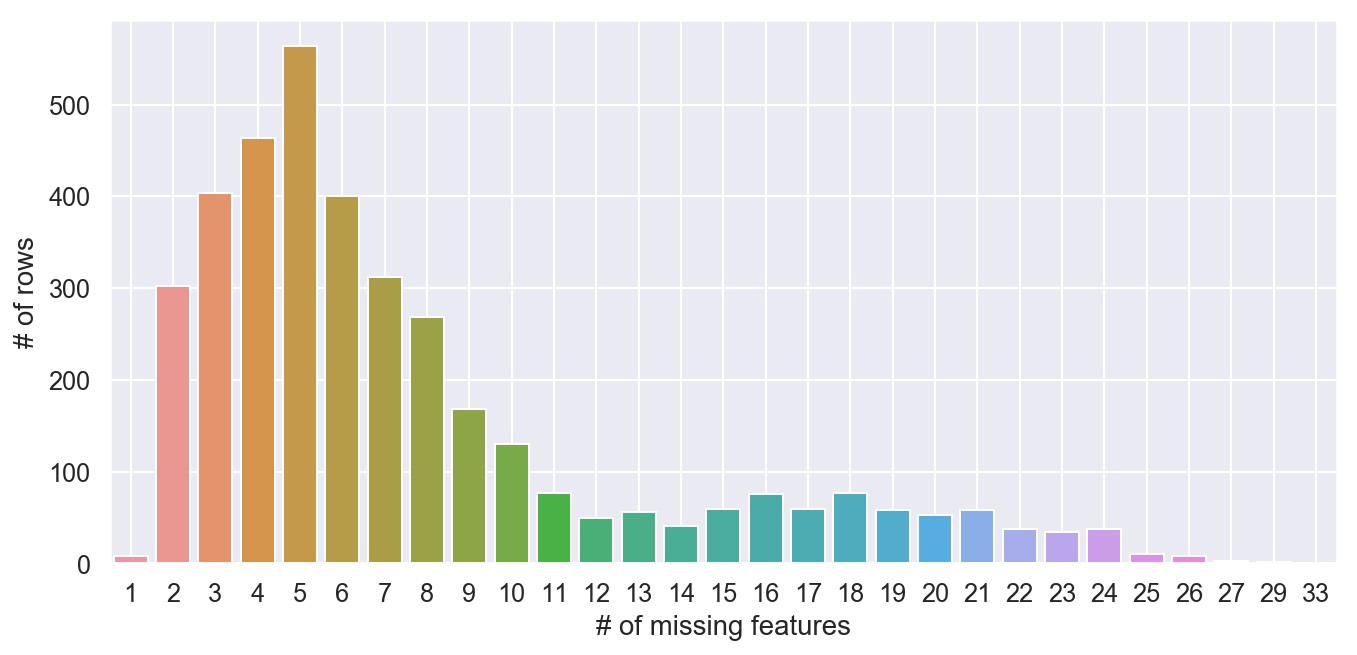

In [ ]:
# Call function 'count_rows_missing()'
utils.count_rows_missing(data=data, city='Seattle', data_name='listings')

The charts above show that the datasets don't seem to have a systematic pattern of groups of rows having unusual numbers of missing features.  

#### Rows in `reviews.csv`

Count of rows per number of missing features in reviews.csv

Boston:
 0 of  6 missing: 68,222 rows
 1 of  6 missing:  53 rows


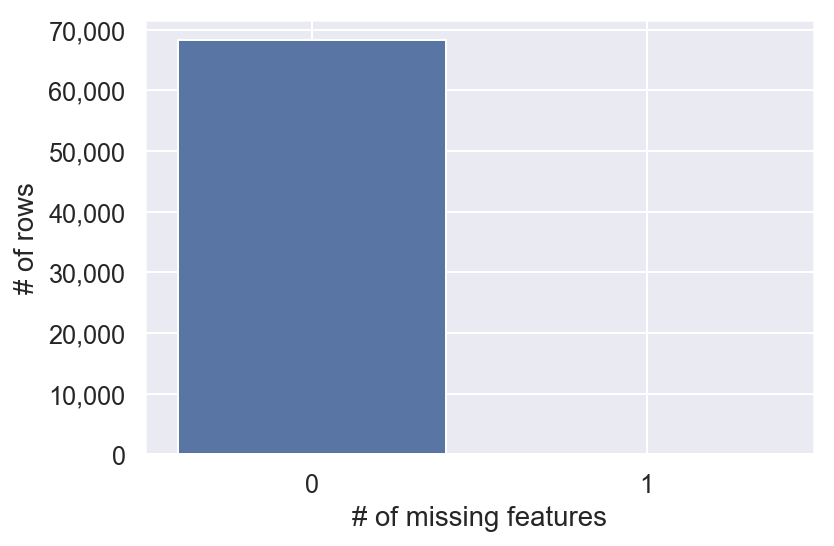

In [ ]:
# Call function 'count_rows_missing()'
utils.count_rows_missing(data=data, city='Boston', data_name='reviews')

Count of rows per number of missing features in reviews.csv

Seattle:
 0 of  6 missing: 84,831 rows
 1 of  6 missing:  18 rows


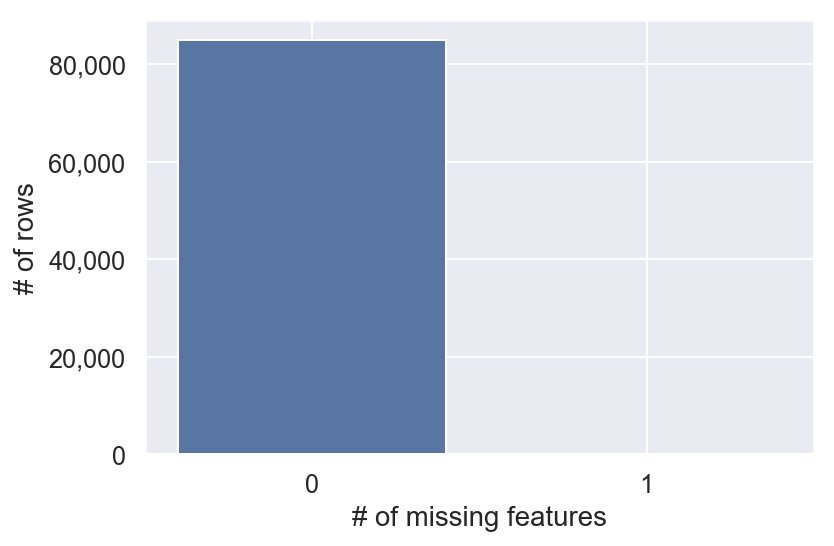

In [ ]:
# Call function 'count_rows_missing()'
utils.count_rows_missing(data=data, city='Seattle', data_name='reviews')

The charts above show that the `reviews.csv` datasets have no rows with more than 1 (out of 6) missing features.

Based on the assessment above I conclude that there is no need to drop any rows for the upcoming analyses. 

---
## Preparing data for analyses 

In order to assess which features require re-encoding, transformations, scaling, etc., we first  need to understand the datatypes in the DataFrames as well as some descriptive statistics.

The utility function `describe_columns()`  provides a high-level view of the properties of the data, excluding missing values. The function returns a data frame including the output of Pandas native `describe()` method, plus the data type by columns and some additional descriptive statistics; namely, the 0.90 and 0.99 quantiles. 

### Re-encode features in `calendar`

In [ ]:
# Call function 'describe_columns()'
utils.describe_columns(data=data, city='Boston', data_name='calendar')

,listing_id,date,available,price
dtype,int64,object,object,object
count,1.30889e+06,1308890,1308890,643037
unique,NaN,365,2,1246
top,NaN,2016-10-28,f,$150.00
freq,NaN,3586,665853,20752
mean,8.44212e+06,NaN,NaN,NaN
std,4.50015e+06,NaN,NaN,NaN
min,3353,NaN,NaN,NaN
25%,4.67932e+06,NaN,NaN,NaN
50%,8.57871e+06,NaN,NaN,NaN


#### `calendar["price"]` — from string to numerical

The data in feature `price` seems to be recorded as strings including the dollar sign ($). Since price is naturally a numerical variable, I re-encode the feature accordingly. 

In [ ]:
# Sample some values in the 'price' feature
for city in data.keys():
    print('Sample of "price" data in {}:'.format(city))
    print(data[city]['calendar']['price'].dropna().sample(n=10).values, '\n')

Sample of "price" data in Boston:
['$119.00' '$52.00' '$90.00' '$140.00' '$80.00' '$155.00' '$229.00'
 '$60.00' '$525.00' '$65.00'] 

Sample of "price" data in Seattle:
['$119.00' '$190.00' '$149.00' '$159.00' '$139.00' '$52.00' '$59.00'
 '$80.00' '$45.00' '$250.00'] 



In [ ]:
# Function: transform price column
def price_re(price_str):
    """Re-encode string of a dollar amount to float.
    
    Args: 
        price_str (str): Price value with dollar symbol and comma.
    
    Returns: 
        price (np.float32)
        
    """
    if isinstance(price_str, str):
        return np.float32(price_str[1:].replace(',', ''))
    else:
        return np.nan

# Test function
temp = '$7,163.00'
print('Test function with string {}.\nOutput: {}'.format(temp, price_re(temp)))

Test function with string $7,163.00.
Output: 7163.0


In [ ]:
# Re-encode 'price'
original_feat = 'price'
eng_feat = 'price_re'
# Loop over cities and apply 'price_re()'
for city in data.keys():
    data[city]['calendar'][eng_feat] = data[city]['calendar'][original_feat]\
        .apply(price_re)

#### `calendar["available"]` — from string to binary numerical

According to the table above, `available` is encoded as a string with two possible unique values.

In [ ]:
# Unique values of 'available'
for city in data.keys():
    print('Unique values of "available" in {}:'.format(city))
    print(data[city]['calendar']['available'].dropna().unique(), '\n')

Unique values of "available" in Boston:
['f' 't'] 

Unique values of "available" in Seattle:
['t' 'f'] 



I re-encode `available` below into a binary, numerical variable.

In [ ]:
# Re-encode 'available'
original_feat = 'available'
eng_feat = 'available_re'
# Loop over cities and transform variable
for city in data.keys():
    data[city]['calendar'][eng_feat] = data[city]['calendar'][original_feat]\
        .apply(lambda x: 1 if x == 't' else 0)

#### `calendar["date"]` — from string to Pandas timestamp

In [ ]:
# Sample some values in the 'date' feature
for city in data.keys():
    print('Sample of "date" feature in {}:'.format(city))
    print(data[city]['calendar']['date'].dropna().sample(n=10).values, '\n')

Sample of "date" feature in Boston:
['2017-08-02' '2017-01-29' '2017-08-22' '2016-12-14' '2017-01-19'
 '2016-10-14' '2016-12-28' '2016-09-27' '2017-05-20' '2017-07-24'] 

Sample of "date" feature in Seattle:
['2016-03-23' '2016-08-16' '2016-05-30' '2016-07-19' '2016-12-11'
 '2016-01-18' '2016-05-01' '2016-03-19' '2016-09-20' '2016-09-05'] 



Dates contained in the `date` feature are recorded as strings. Since dates in this context — panel data — are typically used as a special type of x-axis in visualizations, it is useful to re-encode `date` using Pandas time series/date functionality.

In [ ]:
# Re-encode 'date' into Pandas timestamp
original_feat = 'date'
eng_feat = 'date_re'
# Loop over cities and transform variable
for city in data.keys():
    data[city]['calendar'][eng_feat] = data[city]['calendar'][original_feat]\
        .apply(lambda x: pd.Timestamp(x))

#### Create other time-based features

Below I used the newly re-encoded dates to create features that will be used in the upcoming analyses:
1. `day_of_week`:  Monday = 0, Tuesday = 1, ..., Sunday = 6
2. `day_of_year`:  1, 2, …, 365, 366 (i.e., from Jan-1 to Dec-31)
3. `day_of_sample`:  0, 1, …, 364, 365 (i.e., from first day of sample to last day of sample by city).

In [ ]:
# Loop over cities and create new columns
for city in data.keys():
    # Get dates column as basis for new time features
    dates = data[city]['calendar']['date_re']
    
    # Create 'day_of_week':  Mon = 0, Tue = 1, ..., Sun = 6
    data[city]['calendar']['day_of_week'] = dates.apply(lambda x: x.dayofweek)
    
    # Create 'day_of_year' : 1, 2, ..., 366
    data[city]['calendar']['day_of_year'] = dates.apply(lambda x: x.dayofyear)
    
    # Create 'day_of_sample' : 0, 1, ..., 365
    start_date = dates.min()
    data[city]['calendar']['day_of_sample'] = (dates - start_date)\
        .apply(lambda x: x.days)

In [ ]:
# Call function 'describe_columns()'
utils.describe_columns(data=data, city='Boston', data_name='calendar')

The expanded DataFrame `calendar`, as shown above, contains most data we need for the analysis, modeling, and visualizations below. 

### Re-encode features in `reviews`

#### `reviews["date"]` — from string to Pandas timestamp

In [ ]:
# Re-encode 'date'
original_feat = 'date'
eng_feat = 'date_re'
# Loop over cities and transform variable
for city in data.keys():
    data[city]['reviews'][eng_feat] = data[city]['reviews'][original_feat]\
        .apply(lambda x: pd.Timestamp(x))

In [ ]:
# Call function 'describe_columns()'
utils.describe_columns(data=data, city='Boston', data_name='reviews')

### Add count of reviews to `calendar` datasets

Before jumping into the analyses below, we need to determine whether the quantity of reviews for the listings in the `calendar` datasets is (1) a constant number or (2) a variable that changes across the time dimension of the panel data. 

Statistics concerning reviews per listing are recorded in two of the datasets: `listings` and `reviews`. In `listings`, reviews are recorded as a constant number per listing, since this dataset is cross-sectional (i.e., it doesn't incorporate a time dimension). In `reviews`, on the other hand, reviews are recorded across time; so I will look into the dates of last recorded review in the `reviews` datasets and I will compare these dates with the dates of first recorded prices in the `calendar` datasets. If these date overlap, then it is possible that we could have a measurement for guest reviews over time in the `calendar` dataset.

#### Count of reviews in the `reviews` datasets

In [ ]:
# Print the date of last review in 'reviews'
print('DATE OF LAST RECORDED REVIEW \n') 
for city in data.keys():
    print('{:7}:  {}'.format(city, data[city]['reviews']['date_re'].max()))

In [ ]:
# Print the date of first listing in 'calendar'
print('DATE OF FIRST RECORDED LISTING \n') 
for city in data.keys():
    print('{:7}:  {}'.format(city, data[city]['calendar']['date_re'].min()))

Since there is no temporal overlap between the datasets `reviews` and `calendar`, the quantity of reviews per listing is a constant in the `calendar` datasets.

In [ ]:
# Instantiate dictionaries
reviews_count = dict()
reviews_totals = dict()

for city in data.keys():
    # Create a cumulative sum of reviews received by listing 
    reviews_count[city] = data[city]['reviews']\
        .groupby(by=['listing_id','date_re'])['id']\
        .count().groupby(level=[0]).cumsum()
    
    # Create vectors of total reviews by listing
    reviews_totals[city] = reviews_count[city].groupby(level=0).max()

Below I use the data in the `reviews` datasets to add the column 'total_reviews' to the `calendar` datasets.

In [ ]:
# Add column for 'total_reviews' to the calendar datasets
eng_feat = 'total_reviews'
# Loop over cities and create 'total_reviews'
for city in data.keys():
    data[city]['calendar'][eng_feat] = data[city]['calendar']['listing_id']\
        .apply(lambda x: reviews_totals[city].loc[x] 
               if x in reviews_count[city].index else 0)    

#### Count of reviews in the `listings` datasets

As noted above,the `listings` datasets also include data concerning reviews per listing. 

First I will investigate whether these features have issues with missing data.

In [ ]:
# Print title
print('Percentage of missing values in columns')
print('associated with reviews.')

# Loop over cities
for city in data.keys():
    # Calculate percent missing values per column
    df = data[city]['listings'].filter(like='review', axis=1)
    pc = df.isnull().sum() / df.shape[0] * 100
    # Sort, format, and print series of percentages
    sorted_pc = pc.sort_values(ascending=False).apply(
                    lambda x: '{:2.1f}%'.format(x))
    print('\n{:^25}'.format('— ' + city + ' —'))
    print(sorted_pc)

Most of the columns with data about reviews have around 20% missing values, with the single exception of total reviews (`number_of_reviews`). I will keep this column and add the data to the `calendar` datasets.

In [ ]:
# Add column for 'number_of_reviews' to the calendar datasets
for city in cities:
    data[city]['calendar'] = data[city]['calendar'].merge(
        data[city]['listings'][['number_of_reviews']], how='left', 
        left_on='listing_id', right_on=data[city]['listings']['id'])

#### `total_reviews` vs. `number_of_reviews`

The data in `total_reviews` comes from the `reviews` datasets while `number_of_reviews` comes from the `listings` datasets; here I assess whether these two sources provide the same information:

In [ ]:
temp = data[city]['calendar']['number_of_reviews'].equals(
           data[city]['calendar']['total_reviews'])

print("Does 'number_of_reviews' and 'total_reviews' contain the same data?") 
print("- Answer: {}".format(temp))

The test above confirms that both columns contain the same data measuring the review count per listing.

---
## Business Question 1:

> **How does the average availability of homes vary over time?**

I will address this question from two perspectives:
1. What is the empirical distribution of Airbnb per-listing-availability in year of sample?
2. What is the temporal and seasonal behavior of average availability?

### Home availability in a year of sample

We first would like to know whether all listings are observed the same number of times in the `calendar` DataFrames. 

The utility function `unique_listing_records()` takes in the `calendar` DataFrames, counts the number of observations per `listing_id`, and tabulates the unique values for total observations and the count of listings associated with these unique values. 

In [ ]:
# Call function 'unique_listing_records()'
utils.unique_listing_records(data=data)

There is one listing in Boston for which we have 730 observations. This is a case of duplicate values so we need to drop duplicates from `calendar` and re-run the counts.

In [ ]:
# Loop over cities and drop duplicates in 'calendar'
for city in data.keys():
    data[city]['calendar'].drop_duplicates(keep='first', inplace=True)

# Call function 'unique_listing_records()'
utils.unique_listing_records(data=data)

Now, let’s use the utility function `countplot_availability()`, which takes the `calendar` DataFrame and performs three tasks:
1. Builds a histogram of the distribution of total days in the year-of-sample when listings were recorded as available. 
2. Prints the total number of listings in the dataset for the given city.
3. Prints the start and final dates of the year-of-sample for the given city.

#### Home availability in Boston

In [ ]:
# Call function 'countplot_availability()'
utils.countplot_availability(data=data, city='Boston')

#### Home availability in Seattle

In [ ]:
# Call function 'countplot_availability()'
utils.countplot_availability(data=data, city='Seattle')

In [ ]:
cut = 300
print('Percent of homes with at least {} available nights in a year\n'\
      .format(cut))

for city in cities:
    nights_per_home = data[city]['calendar'].groupby(
        by=['listing_id'])['available_re'].sum()  
    print('{:8}: {:.0f}%'.format(city, 100*np.mean(nights_per_home >= cut)))

#### Understanding average home availability in a year

Excluding both tails — near 0 days and 365 days of availability — the distribution of availability per listing in a year is similar in Boston and Seattle; that is, below approximately 300 days the distribution is fairly uniform, and it seems to increase non-linearly after that. 

Despite the similarities in the middle of the distribution, there is significant difference between the cities if we look at the extremes. For Boston, the clearly dominant mode of the distribution is near 0 days of availability; whereas for Seattle, the dominant mode is near 365 days.

My best guess is that the difference in the tails is a product of different approaches of sampling the Airbnb data — listings and dates — between the two cities (i.e., selection bias). In other words, I have a difficult time coming up with a hypothesis which would explain why these differences persist in the underlying population of Airbnb listings in these two cities. 

A plausible scenario consistent with selection bias is that all the Seattle listings were active on Airbnb during the year of sample (such that hosts were actually managing the availability of their homes on the platform), while a large plurality of Boston listings only became active hosts in the platform after the end of the year of sample for Boston. 

### How does the average availability vary over time? 

The histograms above provide a snapshot of the availability per listing in their respective city and years of sample. But in order to understand the dynamic, temporal behavior of availability in a city we need to aggregate the cross-sectional snapshots of the data and analyze these statistics across the time dimension.

The utility function `time_series_means()` is a flexible function intended to visualize the time-series dimension of the `calendar` DataFrames; for either the proportion of available listings or the average price.

Besides the datasets themselves, the function takes three additional keyword arguments:
1. `variable`: Choose between availability or price data.
2. `city`: Boston, Seattle, or both.
3. `time_ax`: Choose between three different time axes:
	1. `datetime`:  calendar date; i.e., from 2016-01-04 to 2017-01-02
	2. `day_of_year`:  from Jan 1st to Dec 31st
	3. `day_of_sample`:  from 0 to 365
    
#### Availability by date — `availability` vs `datetime`

The time-series figure below plots the percentage of listings marked as available (per city) as function of calendar date. 

The data for Boston covers from 2016-09-06 to 2017-09-05 and the data for Seattle covers from 2016-01-04 to 2017-01-02.

In [ ]:
# Call function 'time_series_means()'
utils.time_series_means(data, variable='availability', city='both', 
                        time_ax='datetime')

Both cities show a similar "ramp up" behavior in average availability in the first three months of each of their corresponding samples. After that, average availability is mostly stable with some small variation. 

Even though the trends look similar across the two cities, the trends settle at very different magnitudes of average availability; with Seattle's being significantly higher. Consistently with what I noted in the previous section, my best guess is that this difference in average availability is a product of different approaches of sampling the Airbnb data — listings and dates — between the two cities (i.e., selection bias). This is as opposed to Seattle and Boston inherently having such different levels of average availability on Airbnb in the long run. 

Finally, the ramp up behavior in availability also looks like an issue of sample selection and not a characteristic of the 'real-world' behavior of Airbnb hosts. I would guess that the datasets were backfilled with calendar observations of listings before these were actually on Airbnb; that is, with the objective of having tidy panel data, with the same dates dimension recorded for all listings. As these yet-to-become Airbnb listings would be recorded as unavailable, this approach would produce an artificially low average availability that would ramp up with time. 

#### Availability by day-of-year — `availability` vs  `day_of_year`

For the second case, I plot the percentage of listings marked as available (per city) as function of day of year; from Jan-1 to Dec 31.

This approach allows for a better comparative analysis of the seasonal behavior of availability in the two cities. 

In [ ]:
# Call function 'time_series_means()'
utils.time_series_means(data, variable='availability', city='both', 
                        time_ax='day_of_year')

Average availability does not seem to show a clear seasonal behavior in these datasets. It is plausible that some of the small dips in availability are associated with high-demand times-of-year, such as Spring Break and the start of Summer.

On the other hand, I'd argue that these plots show non-seasonal and odd behavior of average availability are consistent with my explanation in previous sections regarding the low average availabilities being an artifice of sample selection and dataset construction.

#### Availability by day-of-sample — `availability` vs `day_of_sample`

The final time dimension I explore is `day_of_sample`; from 0 to 365.

This approach allows for a comparative analysis of the trends in average availability as a function of the chronological dimension of the sample.

In [ ]:
# Call function 'time_series_means()'
utils.time_series_means(data, variable='availability', city='both', 
                        time_ax='day_of_sample')

As we can see, the trends of average availability in the two cities are almost identical. Since these two samples correspond to two different spans of calendar dates, I can't think of a good reason why the trends would match in this way, unless the behavior is entirely a product of sample and panel-dataset construction.

---
## Business Question 2:

> **What are the seasonal and weekly patterns of average nightly rates?**

As it was the case with Question 1, this section also makes use of the temporal dimension of the panel data, but in this case we will look into the temporal behavior of average prices in the two cities. 

### Seasonal behavior of average rates
The following three figures show plots of the average prices per city, using the same three time axes used in the last section:
- `datetime`
- `day_of_sample`
- `day_of_year`

Since we are exploring the question of seasonal behavior, the last figure is the most important. It allows a clear comparative analysis of average prices as function of time of year. However, the first two figure can also provide insights about events that are unique or somehow not systematically related to time of year.

#### Average nightly rate by date — `price` vs `datetime`

In [ ]:
# Call function 'time_series_means()'
utils.time_series_means(data, variable='price', city='both', 
                        time_ax='datetime')

The plots indicate that average price per city is a pretty noisy statistic, showing significant within-week variation. Since the Seattle time-series covers a calendar year, it's easier to identify a clear seasonal pattern of higher prices in the Summer. This should become even clearer when we look at prices by time of year.

#### Average nightly rate by day-of-sample — `price` vs `day_of_sample`

In [ ]:
# Call function 'time_series_means()'
utils.time_series_means(data, variable='price', city='both', 
                        time_ax='day_of_sample')

For Boston, average prices in the first third of the year of sample are higher and noisier than any other segment of the plots for both cities. Since `price` only takes values for dates on which a listing is available, the highly variable behavior of prices in Boston is almost surely a product of a smaller sample of available listings and prices, which we observed in Section 5. 

Following the noisier segment in the first 120 days of sample, the Boston average price behaves seems to follow the same weekly cycle as Seattle's average price. That said, Boston prices remain higher than Seattle's for the entire year.

Finally, there is a highly noticeable spike in the average price in Boston that does not seem to be a product of data issues. In other words, there is probably a "real-world" reason for this spike in price. I investigate this issue below. 

#### Average nightly rate by day-of-year — `price` vs `day_of_year`

In [ ]:
# Call function 'time_series_means()'
utils.time_series_means(data, variable='price', city='both', 
                        time_ax='day_of_year')

The plots of average prices by day-of-year provide the following plausible insights:
1. Average prices seem to be increasing independently of season. Thus, I would guess that average prices in this two cities were increasing year over year. 
2. The seasonal behavior of prices is analogous in Boston and Seattle, with average price peaking in the early Summer months and bottoming out in late Winter. 
3. Considering this figure together with the previous two, we can safely guess that the spike in the Boston average price that happens in September is not a product of real conditions in the city. The high and noisy prices are due to a smaller sample of available listings. 
4. The highly noticeable spike in the Boston average price that happens in April of 2017 is most likely a product of some real event that affected the market conditions in the city.

#### Rate spike in Boston — April of 2017

In this section we will look into the spike in the Boston average price that happens in April of 2017. 

The following cells build a plot of average price in Boston for the relevant time window. 

In [ ]:
# Select Boston calendar data for April
bool_idx = data['Boston']['calendar']['date_re'].apply(lambda x: x.month) == 4

# Calculate mean prices in April
prices_april = data['Boston']['calendar'][bool_idx].groupby(
    by=['date_re'])['price_re'].mean()

In [ ]:
# Create figure and subplot  
fig, ax = plt.subplots(figsize=(10, 5))
# Plot mean prices in April
sns.lineplot(data = prices_april, color='salmon')

# Create locator and formatter for x-axis ticks and labels 
rule = plotdates.rrulewrapper(plotdates.WEEKLY, byweekday=0)
locator = plotdates.RRuleLocator(rule)
formatter = plotdates.DateFormatter('%Y-%m-%d')

# Set axes properties
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("$%d")) 
ax.set_ylabel('Price', fontsize=14)  

# Display figure
plt.show()

The plot shows that the spike happened approximately from 2017-04-10 to 2017-04-18. 

Since the **2017 Boston Marathon** took place on Monday, April 17, I think it is safe to say that this was the event that caused the spike in demand and average prices for Airbnb's Boston listings.

### Average nightly rates by day-of-week

In the multiple figures we have already seen, it is clear that average prices in both cities follow some sort of weekly cycle.

The following cell calculates and tabulates the sample average prices by day-of-week for Boston and Seattle. 

In [ ]:
# Print title
print('— Average prices grouped by *day of week* —')
# Translate day_of_week integers to words
days = pd.Series({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 
                  5:'Sat', 6:'Sun'})

# Loop over cities
for city in data.keys():
    # Calculate mean prices by day_of_week
    prices = data[city]['calendar'].groupby(
        by=['day_of_week'])['price_re'].mean()
    # Format and display prices
    df = pd.DataFrame()
    df['day_of_week'] = days
    df['price'] = prices.apply(lambda x: '${:.2f}'.format(round(x, 2)))
    print('\n{}:'.format(city))
    print(df)

Based on these simple averages, the association between average price and day-of-week seems to be analogous across the two cities:
1. The lowest prices are posted for Monday, Tuesday, and Wednesday.
2. Slightly higher prices are posted for Thursdays and Sundays.
3. Weekly prices increase and peak for the weekend evenings, Fridays and Saturdays.

Below I create a new feature for the `calendar` dataset. The binary, numeric feature `fri_sat` corresponds to Friday and Saturday observations.

In [ ]:
# Create 'fri_sat'
original_feat = 'day_of_week'
eng_feat = 'fri_sat'
# Loop over cities and create new variable
for city in data.keys():
    data[city]['calendar'][eng_feat] = data[city]['calendar'][original_feat]\
        .apply(lambda x: 1 if (x == 4 or x == 5) else 0)

In the next sections I rely on the utility function `weekend_prices()`. The function call on `time_series_means()` to explore the within-week variability of average prices; that is, by separating the data in two subsets of prices: 
1. Friday and Saturday evenings, and 
2. the rest of the week.

#### Weekend rates in Seattle

In [ ]:
# Call function weekend_prices()
utils.weekend_prices(data, city='Seattle')

The two figures above clearly show how the noisy average price in Seattle can be smoothed out significantly by separating the data and making one plot of Friday-Saturdays price and another plot of average price for the rest of the week.

The average Fri-Sat price remains approximately 6% higher than the average weekday price during the entire sample. 

#### Weekend rates in Boston

In [ ]:
# Call function weekend_prices()
utils.weekend_prices(data, city='Boston')

In Boston, the gap between average Fri-Sat price and average weekday price is smaller and noisier than Seattle; in the range of 3-4%. 

The gap closes completely during the price spike associated with the 2017 Boston Marathon, presumably due to the event taking place on a Monday and causing a spike in demand for Sunday evening. 

---
## Business Question 3:

> **Is there a clear association between the nightly rate and the number of guest reviews received?**

In the final section of this project I investigate the association between average prices and the quantity of reviews.

It is important to stress the fact that the following analysis does not incorporate the content of the guest reviews. In other words, there is no distinction between good, neutral, and bad reviews. A more complete analysis of the relationship between prices and guest reviews ought to look into the content of the reviews in order to assess how different types of reviews are associated with average price. 

### Descriptive statistics of `total_reviews`

The utility function `countplot_reviews()` takes in the `calendar` dataset, enhanced with the count of reviews, and performs two tasks:
1. Prints descriptive statistics for reviews received. 
2. Builds a histogram of number of reviews by listing. 

In [ ]:
# Call countplot_reviews() 
utils.countplot_reviews(data, 'Seattle', cutoff=None)

The empirical distribution of reviews-per-listing is clearly highly skewed. In order to have a better visualization of the majority of the distribution area, I will cut off the x-axis at the 90th percentile of the distribution: 60 reviews for Seattle and 54 reviews for Boston.  

In [ ]:
# Call countplot_reviews() with cutoff
utils.countplot_reviews(data, 'Seattle', cutoff=60)

In [ ]:
# Call countplot_reviews() with cutoff
utils.countplot_reviews(data, 'Boston', cutoff=54)

Since `total_reviews` only takes non-negative values and we are working with highly skewed distributions in the context of linear models, it will be reasonable to consider different transformations of `total_reviews`.

### General linear model

The general form of the linear regressors to be fitted in the upcoming sections is a model of $price$ for listing $i$ in time $t$, as function of $total.reviews$, $home.size$, and $location$ of listing $i$ — as well as $time.of.year_t$:

\begin{equation*}
price_{it} = f(total\_reviews_i) + g(home\_size_i, location_i) + h(time\_of\_year_t)
\end{equation*}

In order to fit different versions of this model, I built the function `linear_model()`. This function instantiates and fits a scikit-learn linear regression, allowing for some flexibility in the choice of the `price` and `total_reviews` measurements, as well as the choice of the numeric and categorical covariates or features. 

The main steps within the `linear_model()` function are:
1. Instantiate a numeric transformer, to impute missing values (when necessary) and to standardize the values. 
2. Instantiate a categorical transformer, to impute missing values (when necessary) and to perform one-hot encoding.
3. Fit and transform the numeric and categorical features using these transformers.
4. Build the `X` matrix by appending the transformed covariates to the independent variable of interest.
5. Build the `y` vector, considering whether a log transformation is required. 
6. Fit the linear regression model.
7. Print the main coefficient for the independent variable of interest — either the number of reviews or a binary indicator for having any number of reviews. 
8. Return the fitted model, `X`, and `y`.

### Prepare data for linear regression

The models in the upcoming sections will be estimated using modules in **scikit-learn**. Hence, we need to engineer or transform the data into the type of array-like data that is required by scikit-learn functions. 

Additionally, in order to use the data for both cities in the estimation step of the modeling below, I concatenate the datasets for Boston and Seattle into a single DataFrame, `df_lm`. 

In order to keep track of the city, I add the numeric, binary feature `boston` (1 if city is Boston, 0 otherwise). 

In [ ]:
# Instantiate dictionary 
df_lm = dict()
# Control variables to select from 'listings' 
listing_feats = [
    'id', 
    'neighbourhood_cleansed', 
    'zipcode', 
    'bedrooms', 
    'accommodates'
    ]
# Loop over cities
for city in data.keys():
    # Merge 'calendar.csv' and selected features in 'listings.csv' 
    df_lm[city] = data[city]['calendar'].merge(
        data[city]['listings'][listing_feats], how='left', 
            left_on='listing_id', right_on='id')
    
    # Create a binary variable for city (Boston = 1)
    if city == 'Boston': 
        df_lm[city]['boston'] = 1 
    else:
        df_lm[city]['boston'] = 0

In [ ]:
# Transform dictionary into single dataframe incl. both cities
df_lm = pd.concat([df_lm['Boston'], df_lm['Seattle']], axis=0)

Finally, since we are only investigating the relationship between `price` and `total_reviews`, I drop all observations with missing values for price; that is, observations in which a listing is marked as unavailable. 

In [ ]:
# Check for missing values in the new dataframe
df_lm.isnull().sum().sort_values(ascending=False)

In [ ]:
# Drop rows with missing values for price
df_lm = df_lm.dropna(subset=['price_re'])
df_lm.isnull().sum().sort_values(ascending=False)

The last table shows that the remaining dataset only contains observations with a value for `price`. 

However, the table also shows that `zipcode` and `bedrooms` still contain a large number of missing values. Consequently, I will not use these feature to build the terms $location$ and $home.size$ in the general model — instead I will use, respectively, `neighbourhood_cleansed` and `accommodates`.

In [ ]:
# Display first few rows of created dataframe
#df_lm.head()

### Naive, pooled linear model

This is the simplest linear model of `price` as function of `total_reviews`.

\begin{equation*}
log(price_{it}) = \alpha + \beta.total\_reviews_i
\end{equation*}

I call this formulation "naive" because it does not account for characteristics of a home that should obviously be associated with price. Also, this is a "pooled" model because we are aggregating the data across its time dimension.  

In [ ]:
# Call linear_model() and store fitted model
lm_1 = utils.linear_model(data=df_lm, outcome='log_price', 
                          ind_var='total_reviews')

The resulting estimate is **-0.17**. Since our outcome is the log of price, this estimate can be considered a percentage change in the main outcome, price, as function of the marginal review.

In other words the naive-pooled-model estimate suggests that, on average, every additional guest review is associated with a decrease in listing price of 0.17%.

This is counterintuitive if one believes that reviews tend to be positive and associated with good Airbnb hosting; which in turn should provide leverage for host to post higher prices for their homes. 

### Pooled linear model with controls for home size and location

This model incorporates controls for home size and location by including the features `accommodates` and `neighbourhood_cleansed`. However, it still provides a pooled estimate since it collapses the time dimension of the data.  

\begin{equation*}
log(price_{it}) = \alpha + \beta.total\_reviews_i + \gamma.f(max\_occupancy_i, neighborhood_i)
\end{equation*} 

In [ ]:
# Select numeric and categorical control variables
numeric_features = ['accommodates']
categorical_features = ['neighbourhood_cleansed']

# Call linear_model() and store fitted model
lm_2 = utils.linear_model(data=df_lm, outcome='log_price', 
                          ind_var='total_reviews', 
                          numeric_features=numeric_features, 
                          categorical_features=categorical_features)

Adding controls for home size and location produces an estimate that is about half of that of the naive model. The estimate suggests that, on average, every additional guest review is associated with a decrease in listing price of 0.09%.

### Linear model with controls for home size, location, and time trends

This is the first of the models to incorporate the time dimension of the data, by including a linear time trend plus its square and cube.

\begin{equation*}
log(price_{it}) = \alpha + \beta.total\_reviews_i + \gamma.f(max\_occupancy_i, neighborhood_i) + \delta.g(day\_of\_year_t)
\end{equation*}

Below I engineer the necessary features for the time-trend term.

In [ ]:
# Create non-linear time trends
df_lm['day_of_year_2'] = df_lm['day_of_year']**2
df_lm['day_of_year_3'] = df_lm['day_of_year']**3

In [ ]:
# Select numeric and categorical control variables
numeric_features = ['accommodates', 'day_of_year', 
                    'day_of_year_2', 'day_of_year_3']
categorical_features = ['neighbourhood_cleansed']

# Call linear_model() and store fitted model
lm_3, X, y = utils.linear_model(data=df_lm, outcome='log_price', 
                                ind_var='total_reviews',
                                numeric_features=numeric_features, 
                                categorical_features=categorical_features)

The new estimate indicates that if we control for home size, location, and time trends, every additional guest review, on average, is associated with a decrease in listing price of 0.08%.

It looks like adding controls for time-trends does not have a substantial impact on our estimate of interest. This was to be expected since **our independent variable of interest, `total_reviews`, does not itself vary with time in the `calendar` datasets, which implies that the value for the estimate on `total_reviews` is driven by the variation of prices across homes of similar size in the same geographic area.**

### Inference for the full model with controls

Until now we have only looked at the point estimates for the parameter of interest, $\beta$, in all the models. In this section I use tools provided in the module **Statsmodels** to improve our understanding of the precision of our estimates. 

Statsmodels' tools allow us to specify a robust covariance matrix, clustered at the level of `listing_id` (i.e., individual homes), which should result in more conservative confidence interval.

In [ ]:
# Pandas series to Numpy array
listing_ids = df_lm['listing_id'].get_values()
# Run sm.OLS with robust standard errors
results = sm.OLS(y, sm.add_constant(X)).fit(cov_type='cluster', 
                                            cov_kwds={'groups': listing_ids})

In [ ]:
# Extract results summary from OLS fit
summary_tables = results.summary2()
# Select parameters of interest and rename labels
new_index = pd.Series(['alpha', 'beta'])
summary_tables.tables[1] = summary_tables.tables[1][0:2].set_index(new_index)
# Select and print table of results
summary_tables.tables = summary_tables.tables[0:2]
print(summary_tables)

As shown in the table above, the 95% confidence interval for $\beta$ in the full model is **(-0.0011, -0.0006)**.

This implies that if the full model — with controls for home size, location, and time trends — were representative of the real association between listing prices and reviews on Airbnb, we could be highly confident that we had a precise estimate of the underlying parameter $\beta$. 

### Association between listing price and being reviewed   

For this final section of the analysis, I investigate the association between prices and having either 0 reviews or 1 or more reviews. In order to do this, I engineer the indicator feature `reviewed` which takes value 0 for listings without any reviews, and the value 1 for listing with 1 or more reviews. 

In [ ]:
# Create new variable 'reviewed'
df_lm['reviewed'] = df_lm['total_reviews'].apply(lambda x: 0 if x == 0 else 1)

The linear model with full controls is specified below:

\begin{equation*}
log(price_{it}) = \alpha + \beta.reviewed_i + \gamma.f(max\_occupancy_i, neighborhood_i) + \delta.g(day\_of\_year_t)
\end{equation*}

Below I estimate the model, going back to using scikit-learn's linear regressor. 

In [ ]:
# Select numeric and categorical control variables
numeric_features = ['accommodates', 'day_of_year', 
                    'day_of_year_2', 'day_of_year_3']
categorical_features = ['neighbourhood_cleansed']

# Call linear_model() and store fitted model
lm_4 = utils.linear_model(data=df_lm, outcome='log_price', ind_var='reviewed',
                          numeric_features=numeric_features, 
                          categorical_features=categorical_features)

The last estimate for $\beta$ indicates that if we control for home size, location, and time trends, having 1 or more guest reviews is associated with an average decrease in  price of 6%.

Once again, this is a counterintuitive finding if one believes that being a reviewed home provides the host leverage to increase its price. 

On the other hand, if the saliency of bad experiences on Airbnb drive guests to disproportionately post bad reviews, then our measurement would be consistent with that underlying series of events. 

Finally, an alternative explanation would be that there are selection bias problems in the sample with respect to guest reviews. If there is some underlying mechanism by which the reviewed listings are systematically different from the listings with zero reviews, then the average difference in price would be impossible to predict without a conceptual understanding of said systematic differences.